In [73]:
import tensorflow as tf
import os
import random
import math
import sys
import numpy as np
import matplotlib.pyplot as plt

In [74]:
_NUM_SHARDS = 5
_DATA_DIR = "../flower_data/"

In [75]:
def get_filenames_and_classes(dataset_dir, train_val):
    flower_root = os.path.join(dataset_dir, train_val)
    directories = []
    class_names = []
#    print (flower_root)
#     print (os.listdir(flower_root))
    for filename in os.listdir(flower_root):
        path = os.path.join(flower_root, filename)
        if os.path.isdir(path):
            directories.append(path)
            class_names.append(filename)

    photo_filenames = []
#    print (directories)
#    print (class_names)
    for directory in directories:
        for filename in os.listdir(directory):
#             print (filename)
            path = os.path.join(directory, filename)
            photo_filenames.append(path)

    return photo_filenames, sorted(class_names)

In [76]:
image_filenames, image_class_names = get_filenames_and_classes(_DATA_DIR,'flower_photos')

## 1. tf record 파일 생성


In [107]:
 #Helper class that provides TensorFlow image coding utilities.
class ImageReader(object):

    def __init__(self):
        # Initializes function that decodes 1 channel png data.
        self._decode_jpeg_data = tf.placeholder(dtype=tf.string)
        self._decode_jpeg = tf.image.decode_jpeg(self._decode_jpeg_data, channels=3)
    def read_image_dims(self, sess, image_data):
        image = self.decode_jpeg(sess, image_data)
        return image.shape[0], image.shape[1]
    #decode string image data to int image data
    def decode_jpeg(self, sess, image_data):
        image = sess.run(self._decode_jpeg,
                         feed_dict={self._decode_jpeg_data: image_data})
        return image

# make tensorflow record file name
def get_dataset_filename(dataset_dir, split_name, shard_id):
    output_filename = 'flower_%s_%05d-of-%05d.tfrecord' % (
        split_name, shard_id, _NUM_SHARDS)
    return os.path.join(dataset_dir, output_filename)

def int64_feature(values):
    # if value is not tuple or list, make value to list
    if not isinstance(values, (tuple, list)):
        values = [values]
    return tf.train.Feature(int64_list=tf.train.Int64List(value=values))

def bytes_feature(values):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[values]))

def image_to_tfexample(image_data, image_format, height, width, class_id):
    return tf.train.Example(features=tf.train.Features(feature={
      'image/encoded': bytes_feature(image_data),
      'image/format': bytes_feature(image_format),
      'image/class/label': int64_feature(class_id),
      'image/height': int64_feature(height),
      'image/width': int64_feature(width),
    }))

def convert_dataset(split_name, filenames, class_names_to_ids, dataset_dir):
    assert split_name in ['train', 'validation']
    
    num_per_shard = int(math.ceil(len(filenames) / float(_NUM_SHARDS)))

    print ("file len: ",len(filenames), "num per shard: ", num_per_shard)

    with tf.Graph().as_default():
        image_reader = ImageReader()

        with tf.Session('') as sess:

            for shard_id in range(_NUM_SHARDS):
                output_filename = get_dataset_filename(
                    dataset_dir, split_name, shard_id)

                #print (output_filename)
                
                #write tensorflow record file
                #create tfrecord_write
                with tf.python_io.TFRecordWriter(output_filename) as tfrecord_writer:
                    start_ndx = shard_id * num_per_shard
                    end_ndx = min((shard_id + 1) * num_per_shard, len(filenames))
                    for i in range(start_ndx, end_ndx):
                        sys.stdout.write('\r>> Converting image %d/%d shard %d' % (
                            i + 1, len(filenames), shard_id))
                        sys.stdout.flush()

                        # Read the filename:
                        image_data = tf.gfile.FastGFile(filenames[i], 'rb').read()
                        height, width = image_reader.read_image_dims(sess, image_data)
                        
                        class_name = os.path.basename(os.path.dirname(filenames[i]))
                        class_id = class_names_to_ids[class_name]
                        
                        #make tensorflow record object and write
                        example = image_to_tfexample(
                            image_data, b'jpg', height, width, class_id)
                        tfrecord_writer.write(example.SerializeToString())

    sys.stdout.write('\n')
    sys.stdout.flush()

random.shuffle(image_filenames)
# random.shuffle(validation_filenames)
train_list = image_filenames[350:]
val_list = image_filenames[0:350]
class_names_to_ids = dict(zip(image_class_names, range(len(image_class_names))))
print (class_names_to_ids)

convert_dataset('train', train_list, class_names_to_ids,
                     _DATA_DIR)
convert_dataset('validation', val_list, class_names_to_ids,
                     _DATA_DIR)

{'daisy': 0, 'sunflowers': 3, 'dandelion': 1, 'tulips': 4, 'roses': 2}
file len:  3320 num per shard:  664
>> Converting image 3320/3320 shard 4
file len:  350 num per shard:  70
>> Converting image 350/350 shard 4


In [100]:
tf_filename = "../flower_data/flower_train_00000-of-00005.tfrecord"
image = []
format = []
label = []
height = []
width = []

In [102]:
for serialized_example in tf.python_io.tf_record_iterator(tf_filename):
    #create tf record object and parsing
    example = tf.train.Example()
    example.ParseFromString(serialized_example)

    # traverse the Example format to get data
    image.append(example.features.feature['image/encoded'].bytes_list.value)
    format.append(example.features.feature['image/format'].bytes_list.value)
    label.append(example.features.feature['image/class/label'].int64_list.value)
    height.append(example.features.feature['image/height'].int64_list.value)
    width.append(example.features.feature['image/width'].int64_list.value)

print (len(image), len(format), len(label), len(height), len(width))
print (format[1][0], label[1][0], height[1][0], width[1][0])

734 734 734 734 734
b'jpg' 4 333 500


(333, 500)


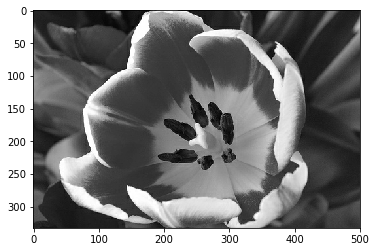

In [103]:
with tf.Session('') as sess:
    #bytes_list image data to int image data
    image = tf.image.decode_png(image[1][0], channels=1)
    image_shape = tf.stack([height[1][0], width[1][0]])
    image = tf.reshape(image, image_shape)
    image = sess.run(image)


print (image.shape)
plt.imshow(image,  cmap='gray')
plt.show()